In [1]:
!pip install --upgrade --editable gym-env

Obtaining file:///C:/Users/samru/anaconda3/lectures/CS698_DeepRL/Project/ForagingReplenishingPatches-main/gym-env
  Attempting uninstall: gym-env
    Found existing installation: gym-env 1.0.0
    Uninstalling gym-env-1.0.0:
      Successfully uninstalled gym-env-1.0.0
  Running setup.py develop for gym-env


In [2]:
import gym
import gym_env
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import copy

env = gym.make('foraging-replenishing-patches-v0')
env.reset()

for i in range(300):
    action = np.random.randint(9)
    state, reward, done, _ = env.step(action)
    print(action, state, reward, done)
    if done:
        break


7 7 0 False
2 2 0 False
2 2 0 False
8 2 63.0 False
0 0 63.0 False
5 5 63.0 False
6 6 63.0 False
7 7 63.0 False
8 7 63.0 False
7 7 63.0 False
0 0 63.0 False
1 1 63.0 False
1 1 63.0 False
2 2 63.0 False
8 2 119.7 False
8 2 170.1 False
1 1 170.1 False
4 4 170.1 False
7 7 170.1 False
4 4 170.1 False
6 6 170.1 False
2 2 170.1 False
8 2 215.1 False
3 3 215.1 False
5 5 215.1 False
7 7 215.1 False
0 0 215.1 False
8 0 215.1 False
2 2 215.1 False
5 5 215.1 False
2 2 215.1 False
8 2 255.6 False
8 2 291.6 False
2 2 291.6 False
2 2 291.6 False
7 7 291.6 False
0 0 291.6 False
4 4 291.6 False
3 3 291.6 False
6 6 291.6 False
8 6 376.20000000000005 False
4 4 376.20000000000005 False
3 3 376.20000000000005 False
3 3 376.20000000000005 False
6 6 376.20000000000005 False
6 6 376.20000000000005 False
2 2 376.20000000000005 False
2 2 376.20000000000005 False
1 1 376.20000000000005 False
5 5 376.20000000000005 False
6 6 376.20000000000005 False
3 3 376.20000000000005 False
6 6 376.20000000000005 False
8 6 45

### Helper functions

In [3]:
def init_env(block_type,final_estimate=[],init=0.0):
    
    env = gym.make('foraging-replenishing-patches-v0',block_type=block_type)
    state=env.reset()
    estimated_rewards=np.array([start_reward]*(env.action_space.n-1))
    noise_rewards=np.array([start_reward]*(env.action_space.n-1))
    visited=np.array([0]*(env.action_space.n-1))
    replenish_rate=np.array([[0.,0.,0.]]*(env.action_space.n-1))
    
    action=np.random.randint(8) #go to random place
    state, current_reward, done, _ = env.step(action)
    state, current_reward, done, _ = env.step(8) #harvest
    rewards=[current_reward]
    visited[state]=1
    updated=False
    actions=[action]
    
    return env,state,action,current_reward,rewards,visited,estimated_rewards,replenish_rate,updated,actions,noise_rewards

**Probability of leaving on each trial**  
 
$P=\frac {1}{1+exp(-[c+\beta(r_t-T_t)])}  $

$r_t$: current reward received from the environment  
$T_t$: current threshold decided by the agent    
$c$: Indicate tendency to continue at current patch irrespective of reward and threshold  
$\beta$: Sensitivity to difference between reward and threshold 

In [4]:
def exploit_or_explore(r,T,c=0.5, beta=0.5):
    
    return 1 / (1 + np.exp(-(c + beta*(r - T)))) #probability of staying 

In [5]:
def select_action(p, s,estimated_rewards=[], type='greedy'):
    
    if np.random.uniform()<p:
        action=8 #harvest
        state, total_reward, done, _ = env.step(action)
        #staying at the patch
        change=False
        leave_time=None 
        actions.append(action)
    else:
        #leaving the patch
        
        change=True
        leave_time=env.time_elapsed #time when agent leaves the patch
        
        temp_estimated_rewards=copy.deepcopy(estimated_rewards)
        temp_estimated_rewards[s]= 0 #ensure the same state is not selected again
    
        if type=='greedy':
            max_states=np.where(temp_estimated_rewards==max(temp_estimated_rewards))[0] #select action greedily
            d=get_distance(s,max_states)
            d=(max(d)-d)+min(d)
            action=np.random.choice(max_states,p=d/sum(d)) #random from best options weighted by distance
        elif type=='softmax':
            p=np.exp(temp_estimated_rewards)/sum(np.exp(temp_estimated_rewards))
            action=np.random.choice(np.arange(8),p=p)
        elif type=='replenish':
             #add accumulated replenishment to estimated rewards
             new_estimated_rewards=(env.time_elapsed-replenish_rate[:,0])*replenish_rate[:,1] + estimated_rewards 
             p=np.exp(temp_estimated_rewards)/sum(np.exp(temp_estimated_rewards))
             action=np.random.choice(np.arange(8),p=p)
            
        state, total_reward, done, _ = env.step(action) #go to a new place
        state, total_reward, done, _ = env.step(8) #harvest
        
        actions.extend((action,8))
            
        global travel_time
        travel_time+=get_distance(s,[state])[0]  #time agent spends travelling
            
    return state, total_reward, done,change, leave_time

In [6]:
#get distance of multiple points from a particular point
def get_distance(state,new_states):

    distance=[]
    for new_state in new_states:
        if abs(new_state-state)<=4:
            d=abs(new_state-state)
        else:
            d=8-abs(new_state-state)
        
        #octagon distances
        if d==2:
            d=1*np.sqrt(2+np.sqrt(2))
        elif d==3:
             d=1*(1+np.sqrt(2))
        elif d==4:
            d=1*np.sqrt(4+2*np.sqrt(2))
            
        distance.append(d)

    return np.array(distance)

In [7]:
def get_threshold(current_reward, estimated_rewards,global_reward=None,w=0.0, type='local'):
    
    distance_cost=get_distance(state,np.arange(8))*current_reward
    if type=='local':
        T=max(np.delete(estimated_rewards-w*distance_cost,state)) #take maximum value available from other states as threshold
    elif type=='global':
        T=global_reward
    return T

In [8]:
def update_estimated_rewards(estimated_rewards,noise_rewards,visited,rewards,global_reward,updated=True,k=3,alpha_global=0.9,type='global'): 
        
        if type=='local':
            #learn the estimated rewards
            if not updated and len(rewards)>k+1: #wait for k actions before updating
                if (np.diff(rewards[-k+1:])>0).all(): #if my last k rewards are positive
                    new_estimate=np.diff(rewards[-k+1:]).mean() #take mean of last k rewards as new estimate
                    estimated_rewards[np.where( visited== 0)[0]]=new_estimate #updated the estimated rewards in places not visited
                    noise_rewards[np.where( visited== 0)[0]]=new_estimate
                    updated=True #updation is a one time event
        
        elif type=='global':
            #use global reward as estimates for not visited states
            current_reward=rewards[-1]-rewards[-2]
            estimated_rewards[np.where( visited== 0)[0]]=global_reward 
            noise_rewards[np.where( visited== 0)[0]]=global_reward
            updated=False #updation is continuous 
            
        return estimated_rewards,global_reward,noise_rewards,updated

In [9]:
def ReplenishRate_update(env,rewards,leave_time,replenish_rate,prev_state,new_state,estimated_rewards,visited):
    
    leave_reward=rewards[-2]-rewards[-3] #reward while leaving the patch
    current_reward=rewards[-1]-rewards[-2] #reward while arriving at new patch
  
    #leaving state
    replenish_rate[prev_state][0]=leave_time #save the time when leaving
    replenish_rate[prev_state][2]=leave_reward #save the last reward received

    #new state
    if visited[new_state]:
        old_time=replenish_rate[new_state][0] #retrieve previous time
        old_reward=replenish_rate[new_state][2] #retrieve previous reward
        
        if env.time_elapsed-old_time>22: #waiting for enough time for the rewards to replenish (only replenishes when other rewarding patches are visited)
            replenish_rate[new_state][1]= (current_reward-old_reward)/(env.time_elapsed-old_time)
        
    return replenish_rate

In [10]:
def add_replenish(replenish_rate,estimated_rewards,noise_rewards,new_state,r=0):
    #add replenishment to rewards
        #only replenish patches where we are not currently foraging from 
        add_reward=[0 if i==new_state else 1 for i in range(len(estimated_rewards))]*replenish_rate[:,1] 
        estimated_rewards+=r*add_reward 
        noise_rewards+=r*add_reward
        
        return estimated_rewards, noise_rewards

In [11]:
def add_noise(noise_rewards,visited,new_state,noise_mean,noise_std, n=0):

    #noise while storing
    if sum(visited)>1: #if visited more than 1 state
            visited[new_state]=0
            #add noise to visited states except current state
            noise_rewards[np.where( visited== 1)[0]] += n*np.random.normal(loc=noise_mean, scale=noise_std)
            visited[new_state]=1
    return noise_rewards

### MVT with local estimates (per patch) and thresholds

### Single episode

In [39]:
#hyperparameter values
start_reward=50. #initial estimated reward for all the patches 
alpha_local=0.99 #learning rate for the local patch reward estimates
c=0.8 
beta=0.8
thresh_type='local' #using a threshold based on local rewards
action_type='greedy' #taking a greedy action when we decide to leave
episodes=1
block_type=1
travel_time=0 
global_reward=0

In [40]:
for e in range(episodes):
        done=False
        env,state,action,current_reward,rewards,visited,estimated_rewards,replenish_rate,updated,\
                                                                        actions,noise_rewards=init_env(block_type)
        while not done:

                estimated_rewards[state]+= alpha_local*(current_reward-estimated_rewards[state]) #change estimated reward only for current state
                T=get_threshold(current_reward, estimated_rewards,global_reward,w=0.,type=thresh_type) #get threshold to take a leave/stay decision 
                p=exploit_or_explore(current_reward,T,c=c, beta=beta) #get probabilitity of exploiting 
                new_state, total_reward, done, change, leave_time=select_action(p, state,estimated_rewards, type=action_type) 
                rewards.append(total_reward)                        
                current_reward=rewards[-1]-rewards[-2]
                state=new_state

Final reward in block 1=18587.699999999986


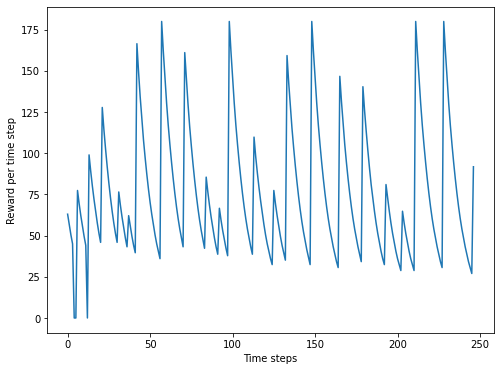

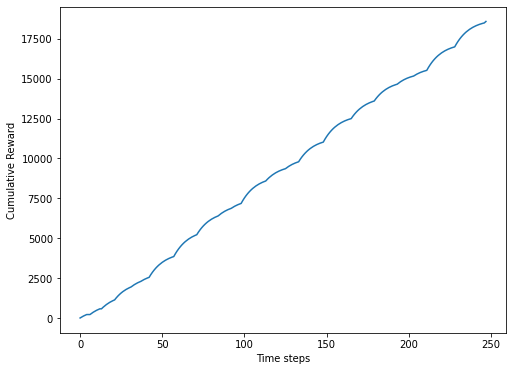

In [41]:
print(f'Final reward in block {block_type}={rewards[-1]}')

plt.figure(figsize=(8,6))
plt.plot(np.arange(len(np.diff(rewards))),np.diff(rewards))
plt.ylabel('Reward per time step')
plt.xlabel('Time steps')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(np.arange(len(rewards)),rewards)
plt.ylabel('Cumulative Reward')
plt.xlabel('Time steps')
plt.show()

The agent is performing well and receives a high reward in the block. The cumulative reward shows a linear trend and is continuously increasing over time. The agent exploits the patch and decides to leave when the received reward is lesser than the threshold.

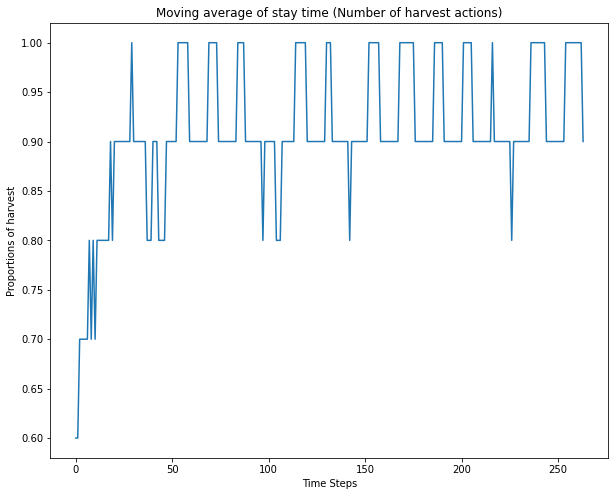

In [47]:
plt.figure(figsize=(10,8))
moving_avg=[]
item=actions
temp=[]
for i in range(len(item)-10):
        harvests=np.mean(np.array(item[i:i+10])==8)
        moving_avg.append(harvests)
plt.plot(np.arange(len(moving_avg)),moving_avg)
plt.xlabel('Time Steps')
plt.ylabel('Proportions of harvest')
plt.title('Moving average of stay time (Number of harvest actions)')
plt.show()

The agent also displays a good understanding of when to exploit and explore the environment, by exploring in the first few time steps and not harvesting much, but gradually starts to exploit more as time passes by.

#### Running over multiple episodes

In [17]:
thresholds=[] #saving threshold for staying/leaving
probs=[] #saving proabilities of staying/leaving
total_rewards=[] #saving total rewards
total_times=[] #saving travel time
episodes=100

for block_type in [1,2,3]:
        #saving the same items per block
        threshs=[]
        ps=[]
        for e in range(episodes):
            travel_time=0
            done=False
            env,state,action,current_reward,rewards,visited,estimated_rewards,replenish_rate,updated,\
                                                                        actions,noise_rewards=init_env(block_type)
            while not done:

                    estimated_rewards[state]+= alpha_local*(current_reward-estimated_rewards[state]) #change estimated reward only for current state
                    T=get_threshold(current_reward, estimated_rewards,global_reward,w=0.,type=thresh_type) #get threshold to take a leave/stay decision 
                    threshs.append([T,state])
                    p=exploit_or_explore(current_reward,T,c=c, beta=beta) #get probabilitity of exploiting 
                    ps.append([p,state])
                    new_state, total_reward, done, change, leave_time=select_action(p, state,estimated_rewards, type=action_type) 
                    rewards.append(total_reward)                        
                    current_reward=rewards[-1]-rewards[-2]
                    
                    if change:
                        visited[new_state]=1

                    state=new_state
                    
            #bookkeeping
            total_rewards.append(rewards[-1])
            total_times.append(travel_time)

        thresholds.append(threshs)
        probs.append(ps)

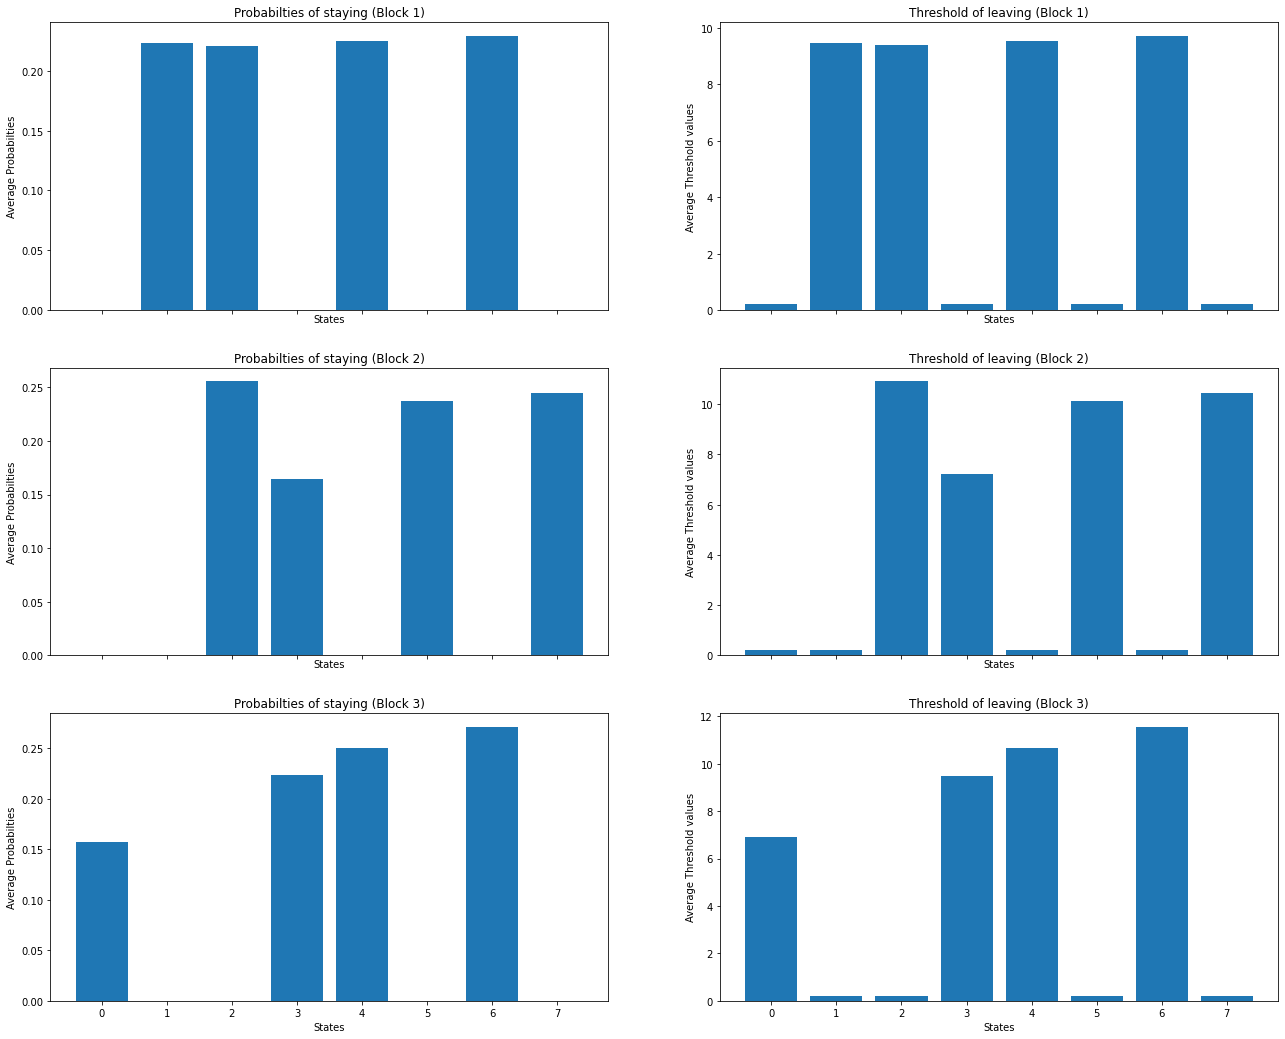

In [18]:
fig,axs=plt.subplots(3,2, figsize=(22,18), sharex=True)

for i in range(3):

    thresh=np.array([0.]*8)
    for item in thresholds[i]:
        thresh[item[1]]+=item[0]

    p_s=np.array([0.]*8)
    for item in  probs[i]:
        p_s[item[1]]+=item[0]
    
    axs[i][0].bar(np.arange(8),p_s/len(probs[i]))
    axs[i][1].bar(np.arange(8),thresh/len(thresholds[i]))
    
    axs[i][0].set_xlabel('States')
    axs[i][0].set_ylabel('Average Probabilties')
    axs[i][0].set_title(f'Probabilties of staying (Block {i+1})')

    axs[i][1].set_xlabel('States')
    axs[i][1].set_ylabel('Average Threshold values')
    axs[i][1].set_title(f'Threshold of leaving (Block {i+1})')

The probabilities of staying at a particular state and the threshold for leaving the state share a monotonic relationship with the rewards and replenshihment rates for the different states. This indicates that the agent has a good estimate of the environment and is making stay/leave decisions optimally.

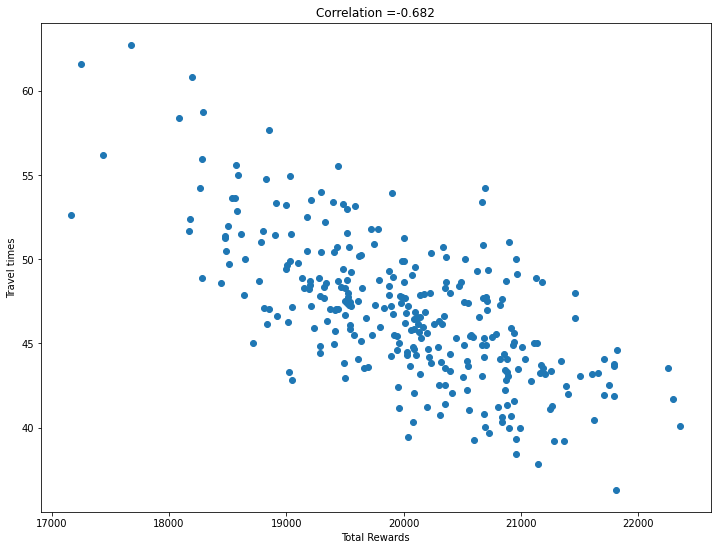

In [19]:
from scipy.stats import pearsonr

plt.figure(figsize=(12,9))
corr, _ = pearsonr(total_rewards,total_times)

plt.title(f'Correlation ={round(corr,3)}')
plt.plot(total_rewards,total_times,'o')
plt.xlabel('Total Rewards')
plt.ylabel('Travel times')
plt.show()

There is a strong relationship between the time taken to travel and the total rewards received in the episode. The agent must therefore spend more time harvesting and only leave when it is absolutely necessary.

### Comparing global vs local thresholds

In [16]:
#hyperparameter values
start_reward=50. #initial estimated reward for all the patches 
alpha_local=0.99 #learning rate for the local patch reward estimates
alpha_global=0.9 #learning rate for the global patch reward estimates
global_reward=50 #inital global reward
c=0.8 
beta=0.8
action_type='greedy' #taking a greedy action when we decide to leave
episodes=30
travel_time=0 

In [14]:
total_rewards_dict={'local':[[],[],[]],'global':[[],[],[]]} #saving total rewards

for thresh_type in ['local','global']: #using both the global average and locally estimated values as the threshold
    for block_type in [1,2,3]:
            temp=[]
            for e in range(episodes):
                travel_time=0
                done=False
                env,state,action,current_reward,rewards,visited,estimated_rewards,replenish_rate,updated,\
                                                                            actions,noise_rewards=init_env(block_type)
                while not done:

                        estimated_rewards[state]+= alpha_local*(current_reward-estimated_rewards[state]) #change estimated reward only for current state
                        global_reward+=alpha_global*(current_reward-global_reward)
                        T=get_threshold(current_reward, estimated_rewards,global_reward,w=0.,type=thresh_type) #get threshold to take a leave/stay decision 
                        p=exploit_or_explore(current_reward,T,c=c, beta=beta) #get probabilitity of exploiting 
                        new_state, total_reward, done, change, leave_time=select_action(p, state,estimated_rewards, type=action_type) 
                        rewards.append(total_reward)                        
                        current_reward=rewards[-1]-rewards[-2]
                        state=new_state

                #bookkeeping
                temp.append(rewards[-1])
                
            total_rewards_dict[thresh_type][block_type-1].append(np.mean(temp))
            

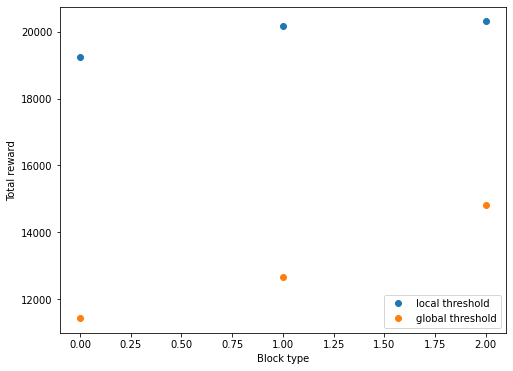

In [15]:
plt.figure(figsize=(8,6))
for key in total_rewards_dict.keys():
    plt.plot(np.arange(3),total_rewards_dict[key],'o',label=f'{key} threshold')
plt.xlabel('Block type')
plt.ylabel('Total reward')
plt.legend()
plt.show()

As we can see, using a threshold based on local reward estimates of each patch provides a sgnificant advantage over a global reward, which is conventionally used in MVT. This is because the environment allows for revisiting patches against conventional foraging environments where the agent cannot revisit a patch. Therefore, storing rewards for each patch would not provide any benefit.

### Learning the initial rewards from the environment 

In [13]:
#hyperparameter values
start_reward=50. #initial estimated reward for all the patches 
alpha_local=0.99 #learning rate for the local patch reward estimates
alpha_global=0.9 #learning rate for the global patch reward estimates
global_reward=0 #inital global reward
c=0.8 
beta=0.8
action_type='greedy' #taking a greedy action when we decide to leave
thresh_type='local'
episodes=100
k=5 #number of actions before updating
travel_time=0 
updated=False

In [14]:
total_rewards_dict={'local':[[],[],[]],'global':[[],[],[]]} #saving total rewards

for est_type in ['local','global']: #using both the global average and locally estimated values as the threshold
    for block_type in [1,2,3]:
            temp=[]
            for e in range(episodes):
                travel_time=0
                done=False
                env,state,action,current_reward,rewards,visited,estimated_rewards,replenish_rate,updated,\
                                                                            actions,noise_rewards=init_env(block_type)
                while not done:

                        estimated_rewards[state]+= alpha_local*(current_reward-estimated_rewards[state]) #change estimated reward only for current state
                        global_reward+=alpha_global*(current_reward-global_reward) #update global reward based on the current reward received
                        T=get_threshold(current_reward, estimated_rewards,global_reward,w=0.,type=thresh_type) #get threshold to take a leave/stay decision 
                        p=exploit_or_explore(current_reward,T,c=c, beta=beta) #get probabilitity of exploiting 
                        new_state, total_reward, done, change, leave_time=select_action(p, state,estimated_rewards, type=action_type) 
                        rewards.append(total_reward)                        
                        current_reward=rewards[-1]-rewards[-2]
                        
                        if change:
                            visited[new_state]=1
                        #update reward estimates
                        estimated_rewards,global_reward,noise_rewards,updated=update_estimated_rewards(estimated_rewards,noise_rewards,visited,rewards,\
                                                            global_reward,updated,k,alpha_global,type=est_type)
                        
                        state=new_state

                #bookkeeping
                temp.append(rewards[-1])
            
            total_rewards_dict[est_type][block_type-1].append(np.mean(temp))
            

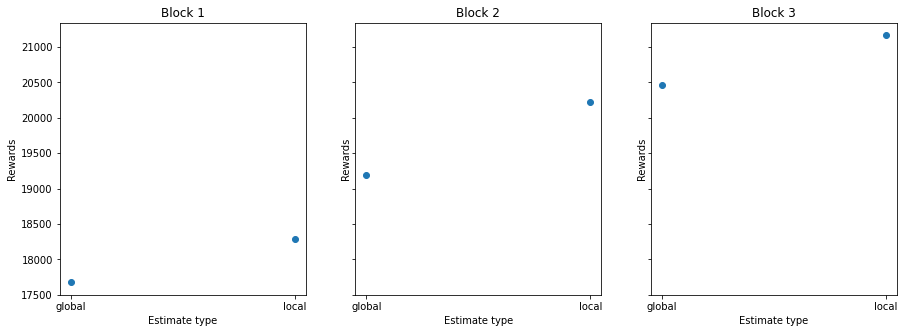

In [15]:
fig,axs=plt.subplots(1,3, figsize=(15,5),sharey=True, sharex=True)

for i in range(3):
    
    axs[i].plot(['global','local'],[total_rewards_dict['global'][i],total_rewards_dict['local'][i]],'o')
    axs[i].set_title(f'Block {i+1}')
    axs[i].set_xlabel('Estimate type')
    axs[i].set_ylabel('Rewards')
plt.show()


As we can see, estimating the initial reward using a one time local update instead of continously updating the reward estimates through a global reward gives slighty higher performance. However, the difference in performance is comparable and not as high as seen in the threshold graph. Results can also vary with global rewards providing better performance in some situations. 

### Memory based agent modelling

In [12]:
#hyperparameter values
start_reward=50. #initial estimated reward for all the patches 
alpha_local=0.99 #learning rate for the local patch reward estimates
c=0.8 
beta=0.8
action_type='greedy' #taking a greedy action when we decide to leave
thresh_type='local'
est_type='local'
episodes=10
travel_time=0 
n=1 #add noise
block_type=1
noise_std=1 #noise distribution std
global_reward=0

In [13]:
total_rewards=[]

for capacity in np.linspace(0,1,num=10):
    for noise_mean in np.linspace(0.1,10,num=10):
            temp=[]
            for e in range(episodes):
                travel_time=0
                done=False
                env,state,action,current_reward,rewards,visited,estimated_rewards,replenish_rate,updated,\
                                                                            actions,noise_rewards=init_env(block_type)
                while not done:            

                        estimated_rewards[state]+= alpha_local*(current_reward-estimated_rewards[state]) #change estimated reward only for current state
                        noise_rewards[state]+= alpha_local*(current_reward-noise_rewards[state]) #use another array to store noisy rewards
                        if np.random.uniform()<capacity:   
                                  current_estimate=copy.deepcopy(estimated_rewards) #if capacity is high use perfect memory more often
                        else:
                                   current_estimate=copy.deepcopy(noise_rewards) #if capacity is low use noisy memory more often
                        T=get_threshold(current_reward, current_estimate,global_reward,w=0.,type=thresh_type) #get threshold to take a leave/stay decision 
                        p=exploit_or_explore(current_reward,T,c=c, beta=beta) #get probabilitity of exploiting 
                        new_state, total_reward, done, change, leave_time=select_action(p, state,current_estimate, type=action_type) 
                        rewards.append(total_reward)                        
                        current_reward=rewards[-1]-rewards[-2]
                        
                        if change:
                            visited[new_state]=1
                            
                        #add noise over time for visited states
                        noise_rewards=add_noise(noise_rewards,visited,new_state,noise_mean,noise_std,n=n)
                        
                        state=new_state

                #bookkeeping
                temp.append(rewards[-1])
            
            total_rewards.append([np.mean(temp),capacity,noise_mean])
            

In [14]:
a=np.array(total_rewards)
capacities=np.unique(a[:,1])
cap_rewards=np.mean(np.split(a[:,0], np.unique(a[:, 1], return_index=True)[1][1:]),axis=1)

noise_means=np.unique(a[:,2])
nmeans_rewards=np.array([0.]*noise_means.shape[0])
for i in range(a.shape[0]):
    nmeans_rewards[np.where(noise_means==a[:,2][i])]+=a[:,0][i]

Reference for above code  
https://stackoverflow.com/questions/38013778/is-there-any-numpy-group-by-function/43094244

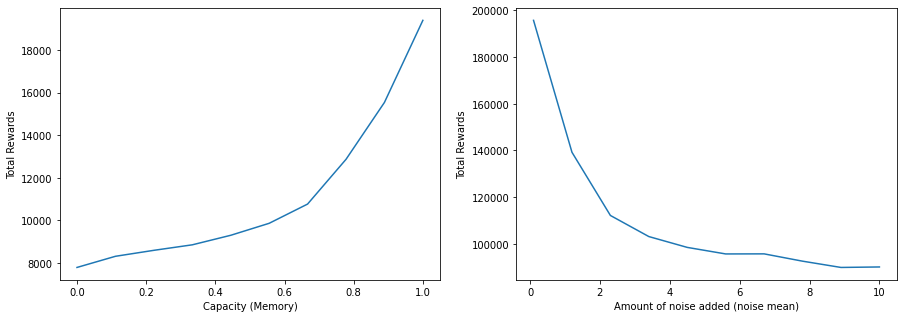

In [15]:
fig,axs=plt.subplots(1,2, figsize=(15,5))
    
axs[0].plot(capacities,cap_rewards)
axs[0].set_xlabel('Capacity (Memory)')
axs[0].set_ylabel('Total Rewards')
    
axs[1].plot(noise_means,nmeans_rewards)
axs[1].set_xlabel('Amount of noise added (noise mean)')
axs[1].set_ylabel('Total Rewards')
    
plt.show()

We can see that as capacity of the agent increases, the amount of rewards increase as the agent uses the true memory more often. As the amount of noise increases, the rewards received decreases as the estimated rewards are further away from the true rewards.

### Adding replenishment rate

In [12]:
#hyperparameter values
start_reward=50. #initial estimated reward for all the patches 
alpha_local=0.99 #learning rate for the local patch reward estimates
c=0.8 
beta=0.8
action_type='greedy' #taking a greedy action when we decide to leave
thresh_type='local'
est_type='local'
episodes=100
global_reward=0

In [13]:
total_rewards=[[],[],[]]
travel_times=[[],[],[]]
rep_rates=[[],[],[]]
for r in np.linspace(0,1,num=11):
    for block_type in [1,2,3]:
        temp_r=[]
        temp_t=[]
        temp_rate=[]
        for e in range(episodes):
                travel_time=0
                done=False
                env,state,action,current_reward,rewards,visited,estimated_rewards,replenish_rate,updated,\
                                                                            actions,noise_rewards=init_env(block_type)
                while not done:            

                        estimated_rewards[state]+= alpha_local*(current_reward-estimated_rewards[state]) #change estimated reward only for current state
                        T=get_threshold(current_reward, estimated_rewards,global_reward,w=0.,type=thresh_type) #get threshold to take a leave/stay decision 
                        p=exploit_or_explore(current_reward,T,c=c, beta=beta) #get probabilitity of exploiting 
                        new_state, total_reward, done, change, leave_time=select_action(p, state,estimated_rewards, type=action_type) 
                        rewards.append(total_reward)                        
                        current_reward=rewards[-1]-rewards[-2]
                        
                        if change:
                            visited[new_state]=1
                            if len(rewards)>3: #ensuring enough travel before updation
                                replenish_rate=ReplenishRate_update(env,rewards,leave_time,replenish_rate,state,\
                                                            new_state,estimated_rewards,visited)
                            
                        estimated_rewards, noise_rewards=add_replenish(replenish_rate,estimated_rewards,noise_rewards,new_state,r)
                        state=new_state

                #bookkeeping
                temp_r.append(rewards[-1])
                temp_t.append(travel_time)
                temp_rate.append(replenish_rate[:,1])
        
        total_rewards[block_type-1].append([np.mean(temp_r)])
        travel_times[block_type-1].append([np.mean(temp_t)]) 
        rep_rates[block_type-1].append([np.mean(temp_rate,axis=0)]) 

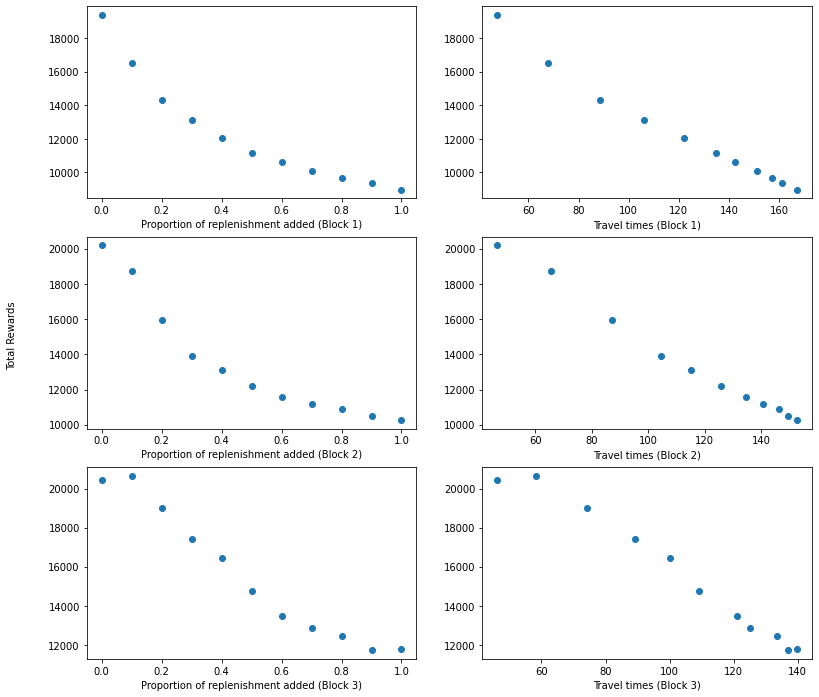

In [14]:
fig,axs=plt.subplots(3,2, figsize=(13,12))

for i in range(3):
    axs[i][0].plot(np.linspace(0,1,num=11),total_rewards[i],'o')
    axs[i][0].set_title(f'')
    axs[i][0].set_xlabel(f'Proportion of replenishment added (Block {i+1})')
    
    axs[i][1].plot(travel_times[i],total_rewards[i],'o')
    #axs[i][1].set_title(f'Block {i+1}')
    axs[i][1].set_xlabel(f'Travel times (Block {i+1})')
    
fig.text(0.04, 0.5, 'Total Rewards', va='center', rotation='vertical')
plt.show()

As we can see, adding replenishment rate reduces the total rewards received. The second column of the graph plotting travel times shows a montonic relationship with the first column. This indicates that the agent spends more time travelling than harvesting, leading to the lower reward received. However, we see that adding replenishment has a different effect in the three blocks. This is because, the three blocks have differing replenishment rates and there is a greater benefit of adding replenishment rate in the blocks where it plays a bigger role (block 3).

### Comparing different action selection strategies

In [12]:
#hyperparameter values
start_reward=50. #initial estimated reward for all the patches 
alpha_local=0.99 #learning rate for the local patch reward estimates
c=0.8 
beta=0.8
episodes=100
thresh_type='local'
est_type='local'
r=0.1
global_reward=0

In [13]:
total_rewards=[[],[],[]]

for action_type in ['greedy','softmax','replenish']:
    for block_type in [1,2,3]:
        temp_r=[]
        for e in range(episodes):
                travel_time=0
                done=False
                env,state,action,current_reward,rewards,visited,estimated_rewards,replenish_rate,updated,\
                                                                            actions,noise_rewards=init_env(block_type)
                while not done:            

                        estimated_rewards[state]+= alpha_local*(current_reward-estimated_rewards[state]) #change estimated reward only for current state
                        T=get_threshold(current_reward, estimated_rewards,global_reward,w=0.,type=thresh_type) #get threshold to take a leave/stay decision 
                        p=exploit_or_explore(current_reward,T,c=c, beta=beta) #get probabilitity of exploiting 
                        new_state, total_reward, done, change, leave_time=select_action(p, state,estimated_rewards, type=action_type) 
                        rewards.append(total_reward)                        
                        current_reward=rewards[-1]-rewards[-2]
                        
                        if change:
                            visited[new_state]=1
                            if len(rewards)>3: #ensuring enough travel before updation
                                replenish_rate=ReplenishRate_update(env,rewards,leave_time,replenish_rate,state,\
                                                            new_state,estimated_rewards,visited)
                            
                        estimated_rewards, noise_rewards=add_replenish(replenish_rate,estimated_rewards,noise_rewards,new_state,r)
                        state=new_state

                #bookkeeping
                temp_r.append(rewards[-1])
        
        total_rewards[block_type-1].append([np.mean(temp_r)]) 

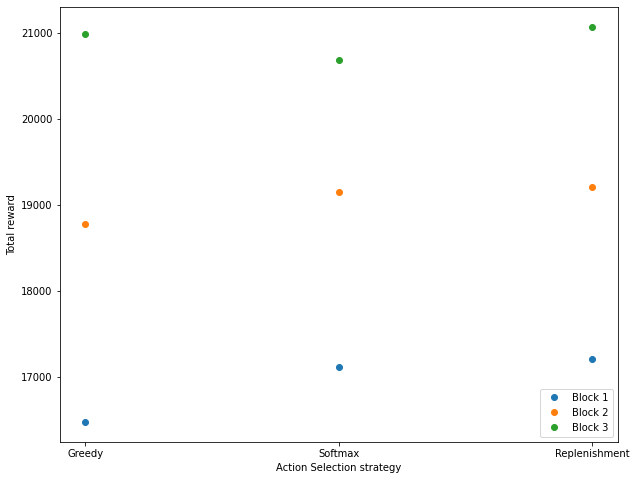

In [14]:
plt.figure(figsize=(10,8))
for i in range(3):
    plt.plot(['Greedy','Softmax','Replenishment'],total_rewards[i],'o', label=f'Block {i+1}')
plt.xlabel('Action Selection strategy')
plt.ylabel('Total reward')
plt.legend()
plt.show()

As we can see, the three action selection strategies provide comparable results with minor differences in the three blocks. This indicates that the type of thresholds used, method of estimation, memory/replenishment rates, play a bigger role than the type of action selection strategy used. This can be explained due to the fact that travel times (harvest/leave decisions) play a big role in the reward received and the action selection strategy comes into the picture only after the agent decides to leave and must figure out where to go next. The 'when' decision plays a bigger role in the environment compared to the 'where' decision.

### Optimal C and beta values

In [12]:
#hyperparameter values
start_reward=50. #initial estimated reward for all the patches 
alpha_local=0.99 #learning rate for the local patch reward estimates
action_type='greedy' #taking a greedy action when we decide to leave
thresh_type='local'
est_type='local'
episodes=10
block_type=1
global_reward=0

In [13]:
total_rewards=[]

for c in np.linspace(0.1,5,num=10):
    for beta in np.linspace(0.1,5,num=10):
            temp=[]
            for e in range(episodes):
                travel_time=0
                done=False
                env,state,action,current_reward,rewards,visited,estimated_rewards,replenish_rate,updated,\
                                                                            actions,noise_rewards=init_env(block_type)
                while not done:            

                        estimated_rewards[state]+= alpha_local*(current_reward-estimated_rewards[state]) #change estimated reward only for current state
                        noise_rewards[state]+= alpha_local*(current_reward-noise_rewards[state]) #use another array to store noisy rewards
                        T=get_threshold(current_reward, estimated_rewards,global_reward,w=0.,type=thresh_type) #get threshold to take a leave/stay decision 
                        p=exploit_or_explore(current_reward,T,c=c, beta=beta) #get probabilitity of exploiting 
                        new_state, total_reward, done, change, leave_time=select_action(p, state,estimated_rewards, type=action_type) 
                        rewards.append(total_reward)                        
                        current_reward=rewards[-1]-rewards[-2]
                        state=new_state

                #bookkeeping
                temp.append(rewards[-1])
            
            total_rewards.append([np.mean(temp),c,beta])        

In [14]:
a=np.array(total_rewards)
cs=np.unique(a[:,1])
c_rewards=np.mean(np.split(a[:,0], np.unique(a[:, 1], return_index=True)[1][1:]),axis=1)

beta_means=np.unique(a[:,2])
beta_rewards=np.array([0.]*beta_means.shape[0])
for i in range(a.shape[0]):
    beta_rewards[np.where(beta_means==a[:,2][i])]+=a[:,0][i]

Reference for above code  
https://stackoverflow.com/questions/38013778/is-there-any-numpy-group-by-function/43094244

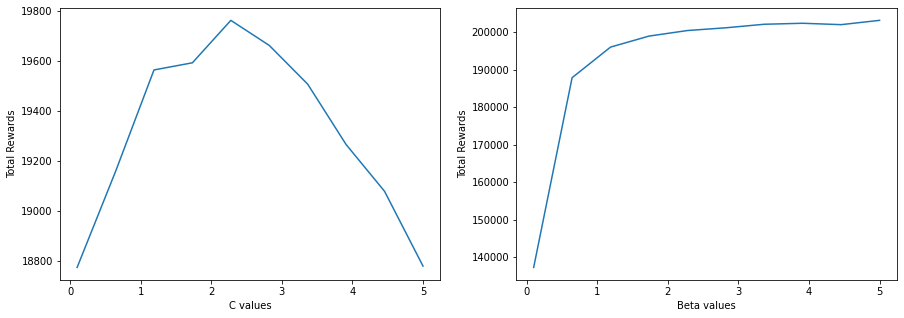

In [15]:
fig,axs=plt.subplots(1,2, figsize=(15,5))
    
axs[0].plot(cs,c_rewards)
axs[0].set_xlabel('C values')
axs[0].set_ylabel('Total Rewards')
    
axs[1].plot(beta_means,beta_rewards)
axs[1].set_xlabel('Beta values')
axs[1].set_ylabel('Total Rewards')
    
plt.show()

The c values seem to peak approximate a normal curve and peak around 2.5. This can be because for small values of c the agent travels too often causing low rates of harvest but for larger values of c, the agent does not travel at all, causing a loss of exploration of the environment. The beta values however seem to increase upto 1.5 and then reach an asymptote afterwards. 